# Decision Trees and Random Forests
## Problem
Again, predict whether it will rain tomorrow.

In [1]:
import opendatasets as od
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import jovian
import os
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

<IPython.core.display.Javascript object>

## Load Data

In [10]:
od.download('https://www.kaggle.com/jsphyg/weather-dataset-rattle-package')

Skipping, found downloaded files in ".\weather-dataset-rattle-package" (use force=True to force download)


In [11]:
os.listdir('Data')

['weatherAUS.csv']

In [2]:
raw_df = pd.read_csv('Data/weatherAUS.csv')
raw_df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [4]:
raw_df.dropna(subset=['RainTomorrow'], inplace=True)

All basic data analysis can be found in 2LogisticRegression file.

## Preprocess
The preprocessing include:
1. train/validation/test split
2. identify independent/dependent variables
3. identify numeric/categorical columns
4. deal with missing values
5. scale data
6. encode categorical data

### Train/Validation/Test split

In [5]:
year = pd.to_datetime(raw_df.Date).dt.year

training_df = raw_df[year < 2015]
validating_df = raw_df[year == 2015]
testing_df = raw_df[year > 2015]

### Independent and Dependent Variables

In [6]:
x_cols = list(training_df.columns)[1:-1]
y_col = 'RainTomorrow'

In [7]:
training_x = training_df[x_cols].copy()
training_y = training_df[y_col].copy()

validating_x = validating_df[x_cols].copy()
validating_y = validating_df[y_col].copy()

testing_x = testing_df[x_cols].copy()
testing_y = testing_df[y_col].copy()

### Numeric and Categorical Variables

In [8]:
numeric_cols = training_x.select_dtypes(include=np.number).columns.tolist()
categorical_cols = training_x.select_dtypes('object').columns.tolist()

Can do a basic feature filtering for numeric variables for numeric variables:

In [9]:
import scipy.stats as stats

def feature_filtering(df):
    choose = ['role']
    threshold = 0.05
    class_label = df['role']
    for feature_name in df.columns:
        if feature_name != 'role':
            feature = df[feature_name]
            count_table = pd.crosstab(class_label, feature)
            chi2_val, p, dof, expected_values = stats.chi2_contingency(count_table, correction=False)
            if p < threshold:
                choose.append(feature_name)
    return df[choose]

### Missing Numeric Value

In [10]:
from sklearn.impute import SimpleImputer

In [11]:
imputer = SimpleImputer(strategy= 'mean').fit(raw_df[numeric_cols])

In [12]:
training_x[numeric_cols] = imputer.transform(training_x[numeric_cols])
validating_x[numeric_cols] = imputer.transform(validating_x[numeric_cols])
testing_x[numeric_cols] = imputer.transform(testing_x[numeric_cols])

### Scale

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler().fit(raw_df[numeric_cols])

In [15]:
training_x[numeric_cols] = scaler.transform(training_x[numeric_cols])
validating_x[numeric_cols] = scaler.transform(validating_x[numeric_cols])
testing_x[numeric_cols] = scaler.transform(testing_x[numeric_cols])

### Categorical Variables

In [16]:
from sklearn.preprocessing import OneHotEncoder

In [17]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(raw_df[categorical_cols])

D:\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [18]:
encoded_cols = list(encoder.get_feature_names_out())

In [19]:
training_x[encoded_cols] = encoder.transform(training_x[categorical_cols])
validating_x[encoded_cols] = encoder.transform(validating_x[categorical_cols])
testing_x[encoded_cols] = encoder.transform(testing_x[categorical_cols])

D:\anaconda3\lib\site-packages\pandas\core\frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
D:\anaconda3\lib\site-packages\pandas\core\frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
D:\anaconda3\lib\site-packages\pandas\core\frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis

In [20]:
X_train = training_x[numeric_cols + encoded_cols]
X_val = validating_x[numeric_cols + encoded_cols]
X_test = testing_x[numeric_cols + encoded_cols]

## Decision Trees
### Training

In [21]:
from sklearn.tree import DecisionTreeClassifier

In [22]:
model = DecisionTreeClassifier(random_state=42)

In [23]:
model.fit(X_train, training_y)

DecisionTreeClassifier(random_state=42)

### Evaluate

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [25]:
y_hat_train = model.predict(X_train)

In [26]:
accuracy_score(training_y, y_hat_train)

0.9999797955307714

In [27]:
confusion_matrix(training_y, y_hat_train)

array([[76705,     0],
       [    2, 22281]], dtype=int64)

Seems work well on data set. But need to evaluate it on validate dataset:

In [31]:
accuracy_score(validating_y, model.predict(X_val))

0.7921188555510418

In [32]:
# Or use
model.score(X_val, validating_y)

0.7921188555510418

See that the model has problem of overfitting!

### Visualization

In [33]:
from sklearn.tree import plot_tree, export_text

[Text(0.5, 0.875, 'Humidity3pm <= 0.715\ngini = 0.349\nsamples = 98988\nvalue = [76705, 22283]'),
 Text(0.25, 0.625, 'Rainfall <= 0.004\ngini = 0.248\nsamples = 82418\nvalue = [70439, 11979]'),
 Text(0.125, 0.375, 'Sunshine <= 0.525\ngini = 0.198\nsamples = 69252\nvalue = [61538, 7714]'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'Humidity3pm <= 0.512\ngini = 0.438\nsamples = 13166\nvalue = [8901, 4265]'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'Humidity3pm <= 0.825\ngini = 0.47\nsamples = 16570\nvalue = [6266, 10304]'),
 Text(0.625, 0.375, 'WindGustSpeed <= 0.279\ngini = 0.499\nsamples = 9136\nvalue = [4804, 4332]'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'Rainfall <= 0.01\ngini = 0.316\nsamples = 7434\nvalue = [1462, 5972]'),
 Text(0.8125, 0.125, '\n  (...)  \n'),
 Text(0.9375, 0.125, '\n  (...)  \n')]

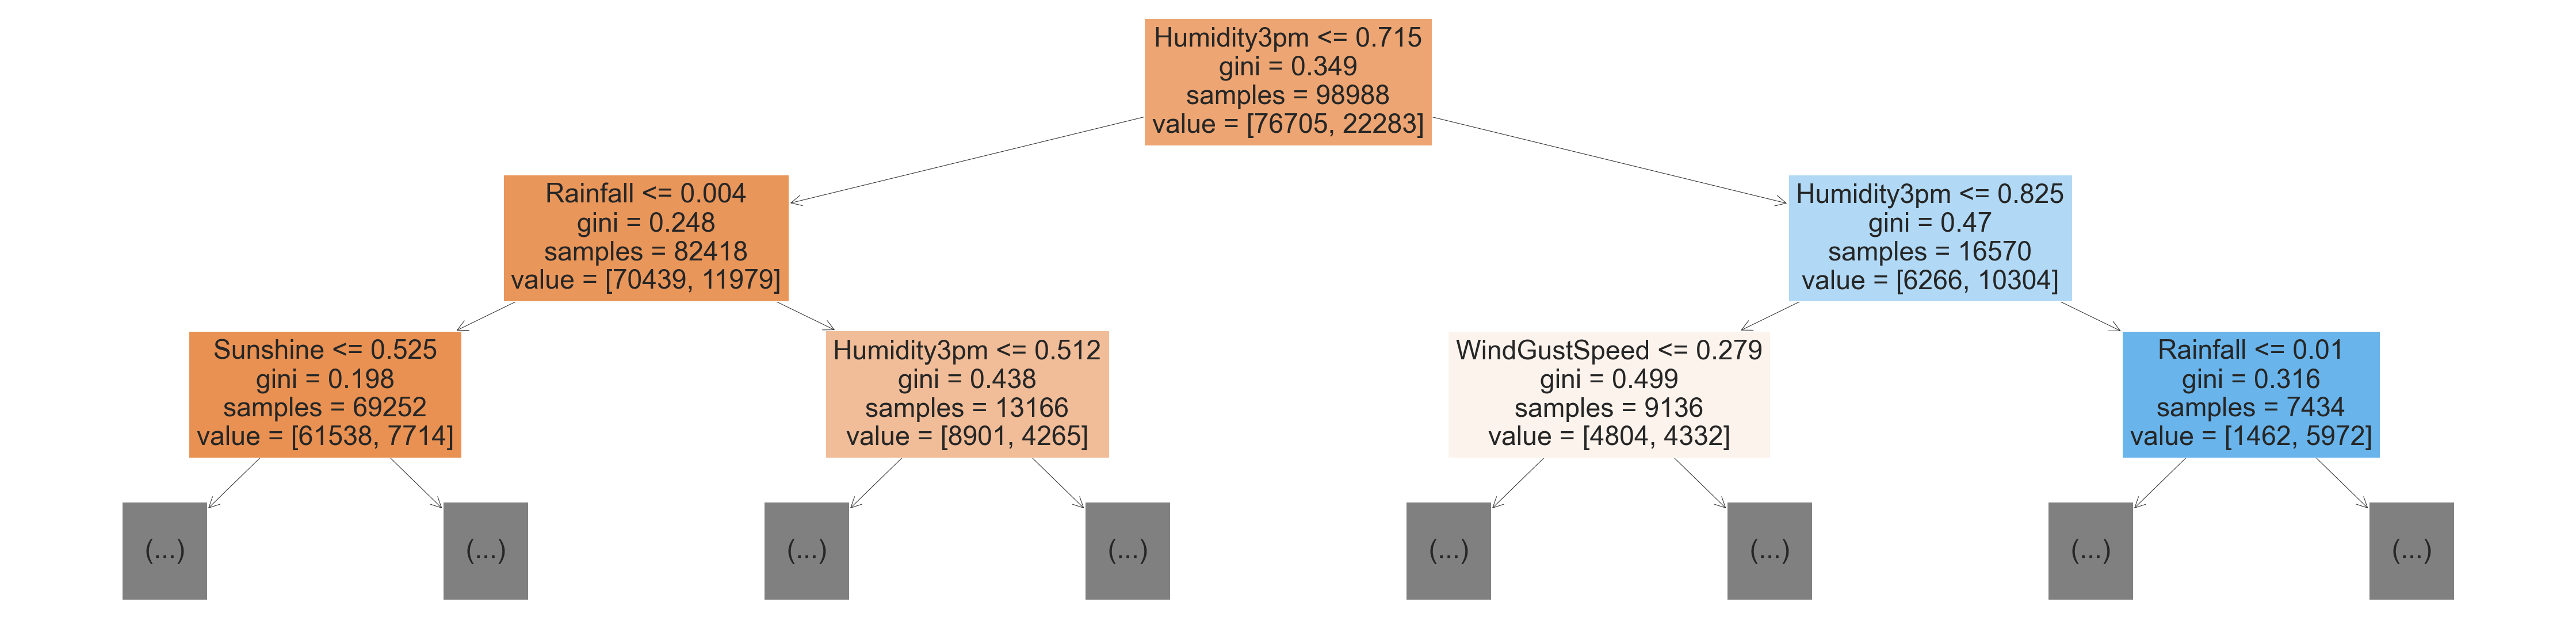

In [34]:
plt.figure(figsize=(80, 20))
plot_tree(model, feature_names=X_train.columns, max_depth=2, filled=True)

Note that this default DT use Gini as splitting measure.

### Feature Importance

In [35]:
model.feature_importances_

array([3.48942086e-02, 3.23605486e-02, 5.91385668e-02, 2.49619907e-02,
       4.94652143e-02, 5.63334673e-02, 2.80205998e-02, 2.98128801e-02,
       4.02182908e-02, 2.61441297e-01, 3.44145027e-02, 6.20573699e-02,
       1.36406176e-02, 1.69229866e-02, 3.50001550e-02, 3.04064076e-02,
       2.24086587e-03, 2.08018104e-03, 1.27475954e-03, 7.26936324e-04,
       1.39779517e-03, 1.15264873e-03, 6.92808159e-04, 1.80675598e-03,
       1.08370901e-03, 1.19773895e-03, 8.87119103e-04, 2.15764220e-03,
       1.67094731e-03, 7.98919493e-05, 1.10558668e-03, 1.42008656e-03,
       4.10087635e-04, 1.09028115e-03, 1.44164766e-03, 9.08284767e-04,
       1.05770304e-03, 6.18133455e-04, 1.80387272e-03, 2.10403527e-03,
       2.74413333e-04, 7.31599405e-04, 1.35408990e-03, 1.54759332e-03,
       1.30917564e-03, 1.07134670e-03, 8.36408023e-04, 1.62662229e-03,
       1.00326116e-03, 2.16053455e-03, 8.46802258e-04, 1.88919081e-03,
       9.29325203e-04, 1.29545157e-03, 1.27604831e-03, 5.12736888e-04,
      

In [36]:
improtance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [37]:
improtance_df.head(10)

,feature,importance
9,Humidity3pm,0.261441
11,Pressure3pm,0.062057
2,Rainfall,0.059139
5,WindGustSpeed,0.056333
4,Sunshine,0.049465
8,Humidity9am,0.040218
14,Temp9am,0.035000
0,MinTemp,0.034894
10,Pressure9am,0.034415
1,MaxTemp,0.032361


## Tuning Parameters and Overfit
Here, discuss 2 major tuning parameters:
1. max_depth
2. max_leaf_nodes

In [38]:
model = DecisionTreeClassifier(max_depth=3, random_state=42)

In [39]:
model.fit(X_train, training_y)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [40]:
model.score(X_train, training_y)

0.8291308037337859

In [41]:
model.score(X_val, validating_y)

0.8334397307178921

See that now the problem of overfit is solved. Note that accuracy is reduced (bias increase). Hence, this is refered to 'bias and variance' trade off.

In [42]:
print(export_text(model, feature_names=list(X_train.columns)))

|--- Humidity3pm <= 0.72
|   |--- Rainfall <= 0.00
|   |   |--- Sunshine <= 0.52
|   |   |   |--- class: No
|   |   |--- Sunshine >  0.52
|   |   |   |--- class: No
|   |--- Rainfall >  0.00
|   |   |--- Humidity3pm <= 0.51
|   |   |   |--- class: No
|   |   |--- Humidity3pm >  0.51
|   |   |   |--- class: No
|--- Humidity3pm >  0.72
|   |--- Humidity3pm <= 0.82
|   |   |--- WindGustSpeed <= 0.28
|   |   |   |--- class: No
|   |   |--- WindGustSpeed >  0.28
|   |   |   |--- class: Yes
|   |--- Humidity3pm >  0.82
|   |   |--- Rainfall <= 0.01
|   |   |   |--- class: Yes
|   |   |--- Rainfall >  0.01
|   |   |   |--- class: Yes



In [43]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md, random_state=42)
    model.fit(X_train, training_y)
    train_acc = 1 - model.score(X_train, training_y)
    val_acc = 1 - model.score(X_val, validating_y)
    return {'Max Depth': md, 'Training Error': train_acc, 'Validation Error': val_acc}

In [44]:
%%time
errors_df = pd.DataFrame([max_depth_error(md) for md in range(1, 21)])

Wall time: 26.9 s


In [45]:
errors_df

,Max Depth,Training Error,Validation Error
0,1,0.184315,0.177935
1,2,0.179547,0.172712
2,3,0.170869,0.166560
3,4,0.165707,0.164355
4,5,0.160676,0.159074
5,6,0.156271,0.157275
6,7,0.153312,0.154605
7,8,0.147806,0.158029
8,9,0.140906,0.156578
9,10,0.132945,0.157333


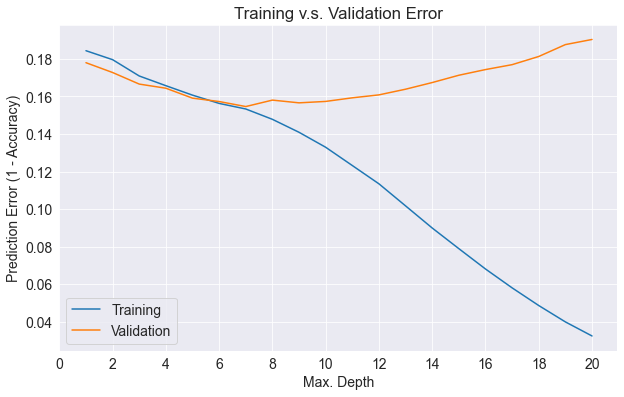

In [46]:
plt.figure()
plt.plot(errors_df['Max Depth'], errors_df['Training Error'])
plt.plot(errors_df['Max Depth'], errors_df['Validation Error'])
plt.title('Training v.s. Validation Error')
plt.xticks(range(0, 21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation'])

Can see that Training error always drop when depth increase, while validation error will drop to an 'optimum' value, then increase when max_depth increase. In later case, is considered to have overfit issue.
In this case, 7 seems to be the best value. (Although this is better to be chosen by cross validation)

In [47]:
model = DecisionTreeClassifier(max_depth=7, random_state=42).fit(X_train, training_y)
model.score(X_val, validating_y)

0.8453949277465034

Another tuning variable is max_leaf_nodes:

In [103]:
model = DecisionTreeClassifier(max_leaf_nodes=128, random_state=42)

In [104]:
model.fit(X_train, training_y)

DecisionTreeClassifier(max_leaf_nodes=128, random_state=42)

In [105]:
model.score(X_train, training_y)

0.8480421869317493

In [106]:
model.score(X_val, validating_y)

0.8442342290058615

In [107]:
model.tree_.max_depth

12

It seems that this does not give overfit either.

In [111]:
def max_depth_error(mnodes):
    model = DecisionTreeClassifier(max_leaf_nodes=mnodes, random_state=42)
    model.fit(X_train, training_y)
    train_acc = 1 - model.score(X_train, training_y)
    val_acc = 1 - model.score(X_val, validating_y)
    return {'Max Nodes': mnodes, 'Training Error': train_acc, 'Validation Error': val_acc}

In [118]:
errors_df = pd.DataFrame([max_depth_error(mnodes) for mnodes in range(2, 200)])

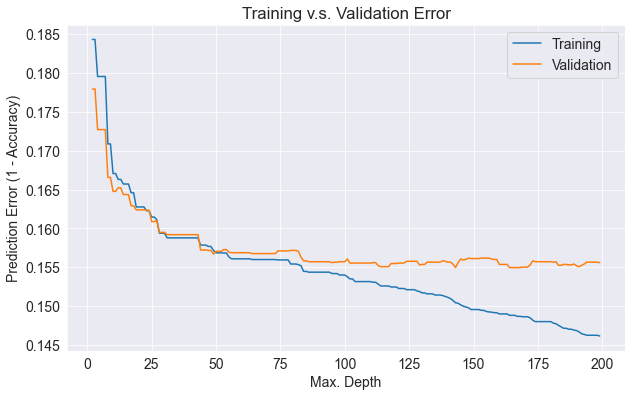

In [119]:
plt.figure()
plt.plot(errors_df['Max Nodes'], errors_df['Training Error'])
plt.plot(errors_df['Max Nodes'], errors_df['Validation Error'])
plt.title('Training v.s. Validation Error')
# plt.xticks(range(0, 21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation'])

In [124]:
def max_depth_error(ndepth, mnodes):
    model = DecisionTreeClassifier(max_depth=ndepth, max_leaf_nodes=mnodes, random_state=42)
    model.fit(X_train, training_y)
    train_acc = 1 - model.score(X_train, training_y)
    val_acc = 1 - model.score(X_val, validating_y)
    return {'Max Depth': ndepth, 'Max Nodes': mnodes, 'Training Error': train_acc, 'Validation Error': val_acc}

In [128]:
min = max_depth_error(1, 2)['Validation Error']
for ndepth in range(5, 21):
    for mnodes in range(20, 50):
        if min > max_depth_error(ndepth, mnodes)['Validation Error']:
            min = max_depth_error(ndepth, mnodes)['Validation Error']
min

0.156694329986652

In [129]:
1 - min

0.843305670013348

## Random Forest
This is a process that train few trees and use a way to 'average' them into one output. And in each split step, choose split point from a fixed size random subset of features to further high variance.

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
model = RandomForestClassifier(n_jobs=-1, random_state=42)

In [53]:
model.fit(X_train, training_y)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [54]:
model.score(X_train, training_y)

0.9999494888269285

In [55]:
model.score(X_val, validating_y)

0.8566537055307295

Again an overfitting issue.

In [154]:
model.estimators_[0]

DecisionTreeClassifier(max_features='sqrt', random_state=1608637542)

[Text(0.5, 0.875, 'Sunshine <= 0.403\ngini = 0.347\nsamples = 62607\nvalue = [76887, 22101]\nclass = No'),
 Text(0.25, 0.625, 'Pressure9am <= 0.609\ngini = 0.499\nsamples = 11288\nvalue = [9272, 8542]\nclass = No'),
 Text(0.125, 0.375, 'Cloud9am <= 0.833\ngini = 0.475\nsamples = 6067\nvalue = [3702, 5808]\nclass = Yes'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'WindGustDir_NNE <= 0.5\ngini = 0.442\nsamples = 5221\nvalue = [5570, 2734]\nclass = No'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'RainToday_Yes <= 0.5\ngini = 0.278\nsamples = 51319\nvalue = [67615, 13559]\nclass = No'),
 Text(0.625, 0.375, 'Pressure9am <= 0.521\ngini = 0.207\nsamples = 41960\nvalue = [58514, 7796]\nclass = No'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'Pressure9am <= 0.614\ngini = 0.475\nsamples = 9359\nvalue = [9101, 5763]\nclass = No'),
 

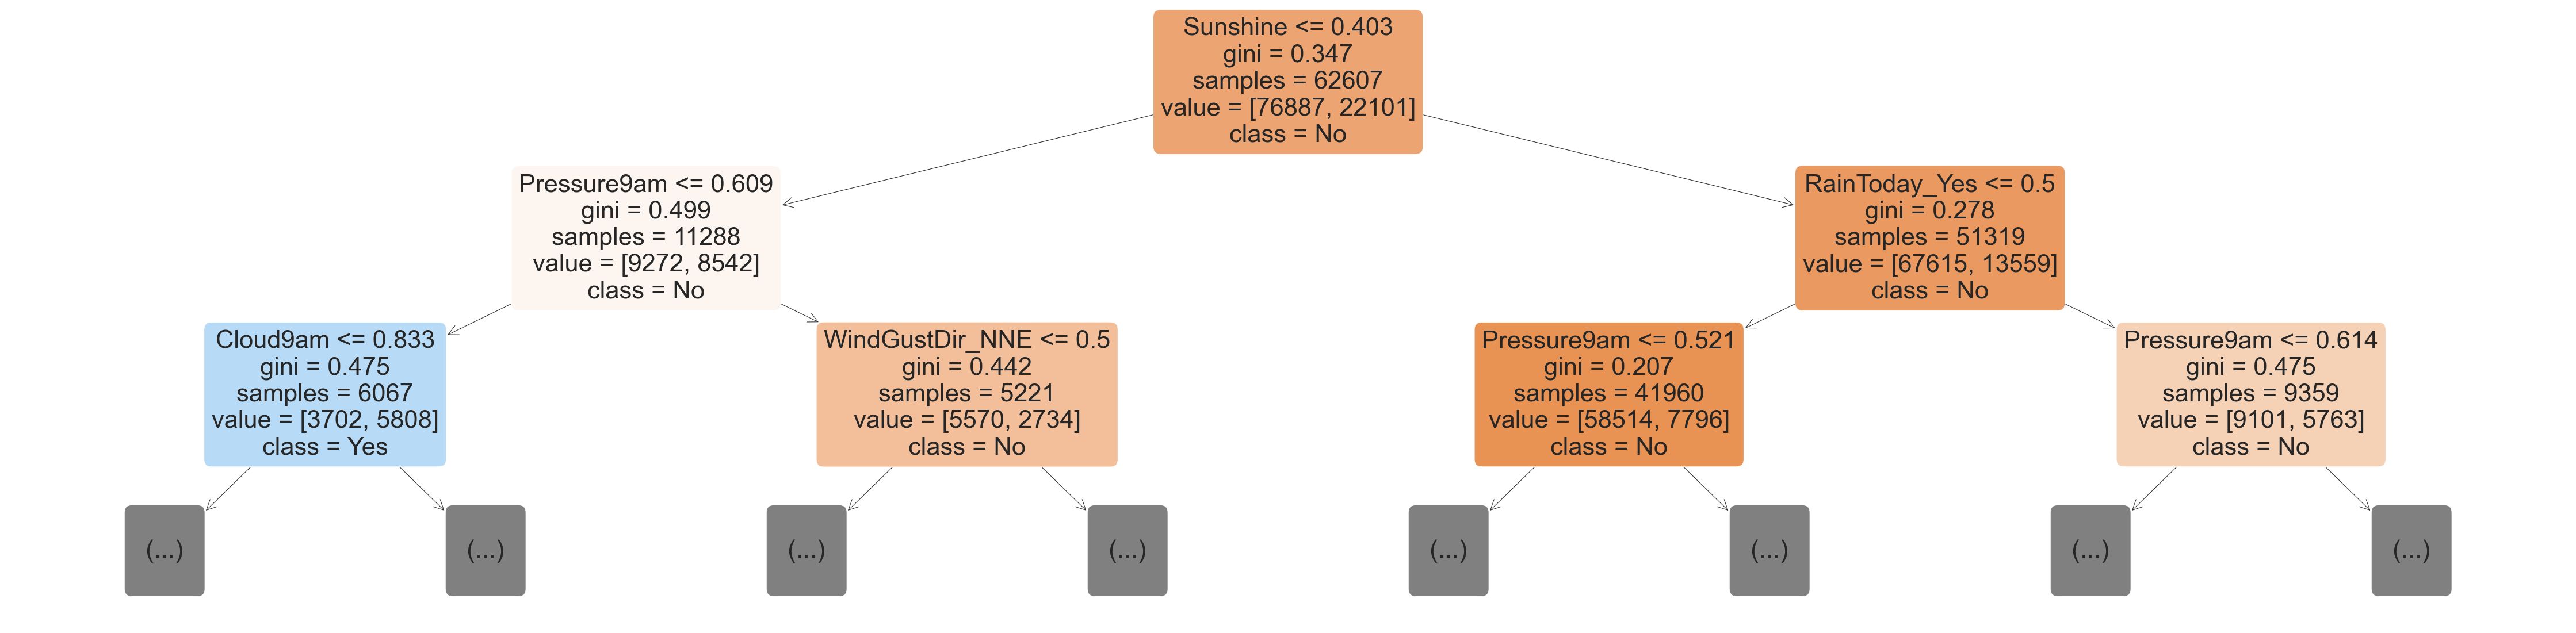

In [155]:
plt.figure(figsize=(80, 20))
plot_tree(model.estimators_[0], max_depth=2, feature_names=X_train.columns, filled=True, rounded=True,
          class_names=model.classes_)

[Text(0.5, 0.875, 'RainToday_Yes <= 0.5\ngini = 0.349\nsamples = 62610\nvalue = [76714, 22274]\nclass = No'),
 Text(0.25, 0.625, 'WindGustDir_ESE <= 0.5\ngini = 0.262\nsamples = 48715\nvalue = [65024, 11930]\nclass = No'),
 Text(0.125, 0.375, 'Pressure3pm <= 0.505\ngini = 0.267\nsamples = 46043\nvalue = [61211, 11515]\nclass = No'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'Humidity3pm <= 0.665\ngini = 0.177\nsamples = 2672\nvalue = [3813, 415]\nclass = No'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'WindSpeed3pm <= 0.333\ngini = 0.498\nsamples = 13895\nvalue = [11690, 10344]\nclass = No'),
 Text(0.625, 0.375, 'Sunshine <= 0.534\ngini = 0.495\nsamples = 11567\nvalue = [10070, 8283]\nclass = No'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'Sunshine <= 0.424\ngini = 0.493\nsamples = 2328\nvalue = [1620, 2061]\nclass = Yes

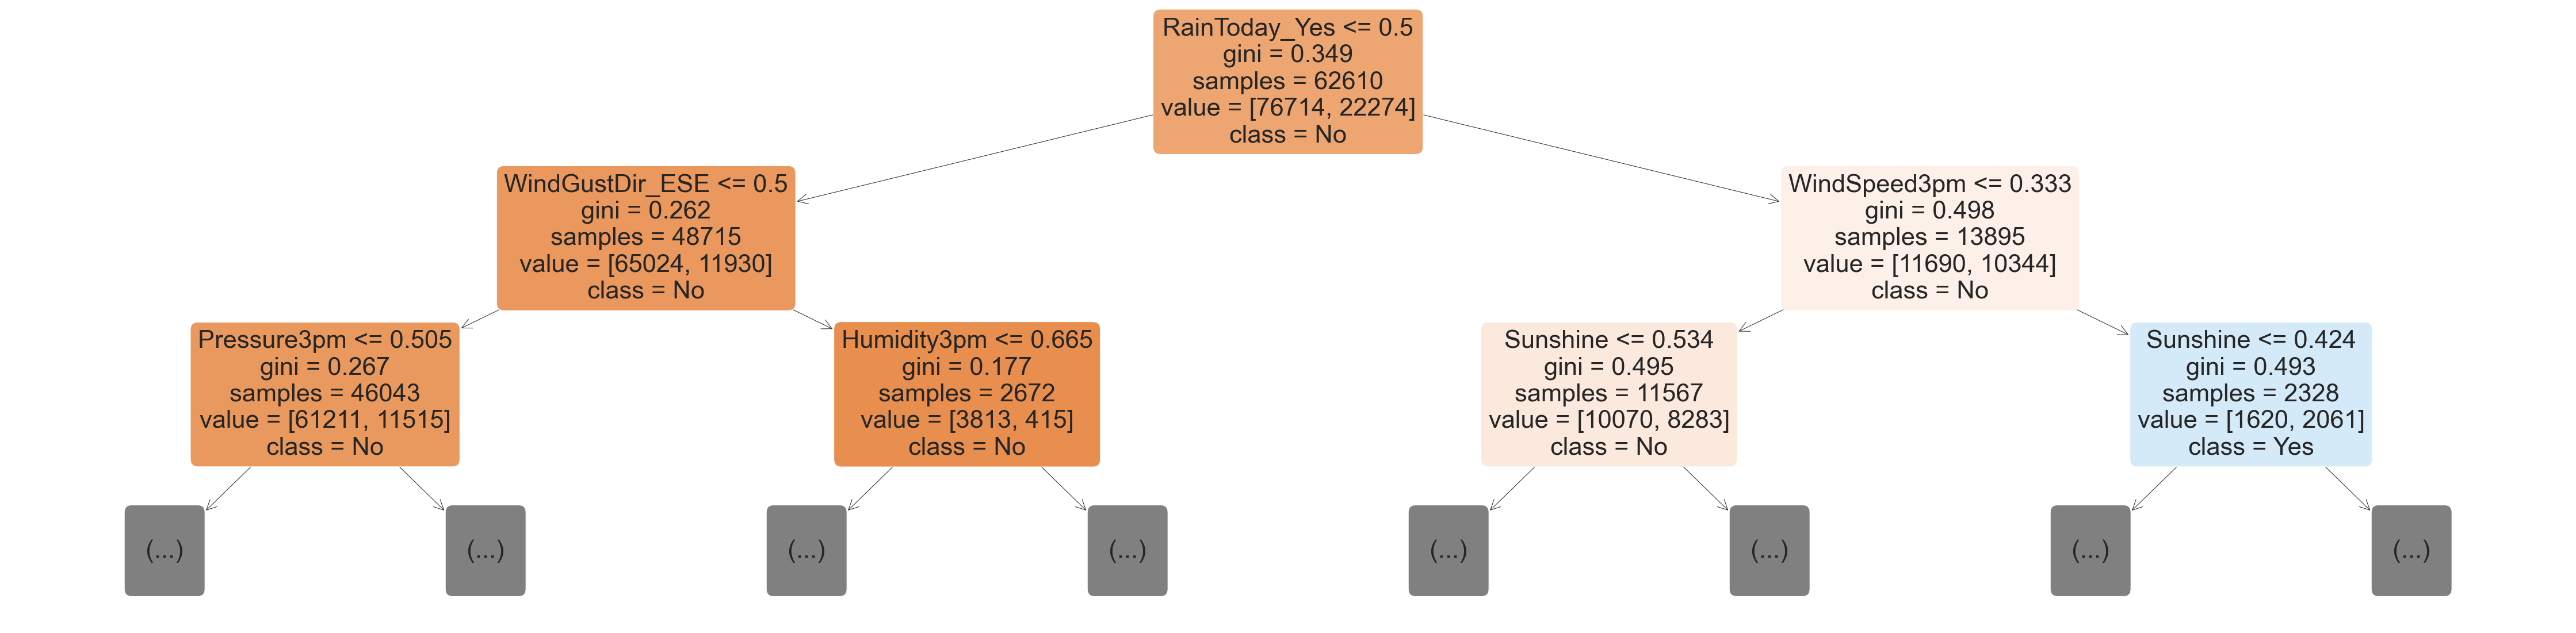

In [156]:
plt.figure(figsize=(80, 20))
plot_tree(model.estimators_[20], max_depth=2, feature_names=X_train.columns, filled=True, rounded=True,
          class_names=model.classes_)

In [157]:
len(model.estimators_)

100

Now, prove that none of the individual trees have a better validation accuracy than the Random Forest:

In [173]:
rain_codes = {'No': 0, 'Yes': 1}
validating_y_code = validating_y.map(rain_codes)

In [195]:
max_accuracy = np.min([model.estimators_[index].score(X_val.values, validating_y_code) for index in range(0, 100)])
max_accuracy > model.score(X_val, validating_y)

List the importance of each features:

In [197]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [198]:
importance_df.head(10)

,feature,importance
9,Humidity3pm,0.139904
4,Sunshine,0.053696
11,Pressure3pm,0.052713
8,Humidity9am,0.050051
2,Rainfall,0.048077
10,Pressure9am,0.047944
5,WindGustSpeed,0.047477
15,Temp3pm,0.044379
1,MaxTemp,0.041865
0,MinTemp,0.041199


## Tuning in Random Forest

In [63]:
base_model = RandomForestClassifier(random_state=42, n_jobs=-1).fit(X_train, training_y)

In [64]:
base_train_accuracy = base_model.score(X_train, training_y)
base_val_accuracy = base_model.score(X_val, validating_y)

In [65]:
base_accuracy = base_train_accuracy, base_val_accuracy
base_accuracy

(0.9999494888269285, 0.8566537055307295)

Still have problem of overfitting with default parameters:
### n_estimators

In [208]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=10)

In [209]:
model.fit(X_train, training_y)

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)

In [210]:
model.score(X_train, training_y), model.score(X_val, validating_y)

(0.986958015112943, 0.8485868492832686)

Make a plot to see what happened:

In [213]:
def n_estimators_error(ne):
    model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=ne)
    model.fit(X_train, training_y)
    train_acc = 1 - model.score(X_train, training_y)
    val_acc = 1 - model.score(X_val, validating_y)
    return {'No. Estimators': ne, 'Training Error': train_acc, 'Validation Error': val_acc}

In [219]:
errors_df = pd.DataFrame([n_estimators_error(ne * 10) for ne in range(1, 20)])

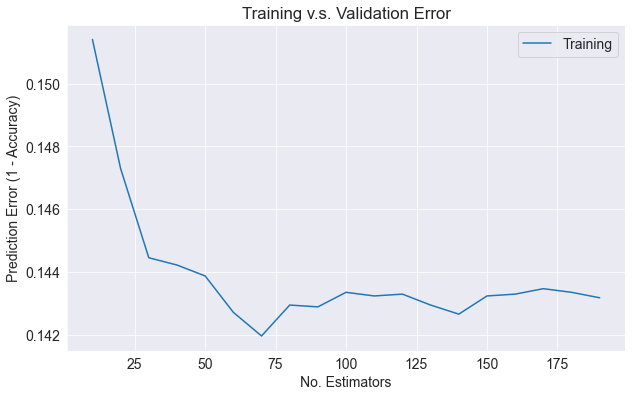

In [221]:
plt.figure()
# plt.plot(errors_df['No. Estimators'], errors_df['Training Error'])
plt.plot(errors_df['No. Estimators'], errors_df['Validation Error'])
plt.title('Training v.s. Validation Error')
# plt.xticks(range(0, 21, 2))
plt.xlabel('No. Estimators')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation'])

### max_depth and max_leaf_nodes

In [49]:
def test_params(**params):
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(X_train, training_y)
    return {'Training Error': model.score(X_train, training_y), 'Validation Error': model.score(X_val, validating_y)}

In [223]:
test_params(max_depth=26)

(0.9814826039519942, 0.8572340549010504)

In [224]:
test_params(max_leaf_nodes=2**20)

(0.9999595910615429, 0.8568278103418258)

In [231]:
errors_df = pd.DataFrame([test_params(max_depth=ne) for ne in range(1, 20)])

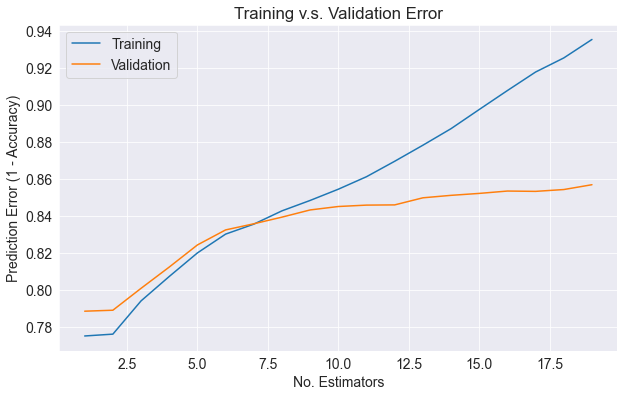

In [235]:
plt.figure()
plt.plot(list(range(1, 20)), errors_df[0])
plt.plot(list(range(1, 20)), errors_df[1])
plt.title('Training v.s. Validation Error')
# plt.xticks(range(0, 21, 2))
plt.xlabel('No. Estimators')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation'])

In [237]:
errors_df = pd.DataFrame([test_params(max_leaf_nodes=2**n) for n in range(5, 20)])

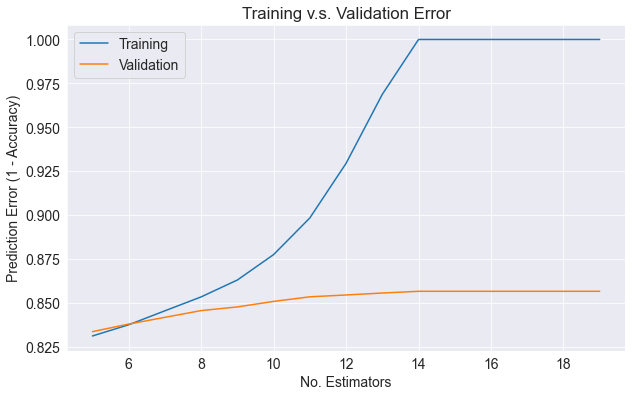

In [238]:
plt.figure()
plt.plot(list(range(5, 20)), errors_df[0])
plt.plot(list(range(5, 20)), errors_df[1])
plt.title('Training v.s. Validation Error')
# plt.xticks(range(0, 21, 2))
plt.xlabel('No. Estimators')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation'])

### max_features

In [239]:
test_params(max_features='log2')

(0.9999595910615429, 0.8558992513493123)

In [240]:
test_params(max_features=3)

(0.9999494888269285, 0.8543323080494458)

In [241]:
base_accuracy

(0.9999494888269285, 0.8566537055307295)

In [242]:
errors_df = pd.DataFrame([test_params(max_features=n) for n in range(1, 10)])

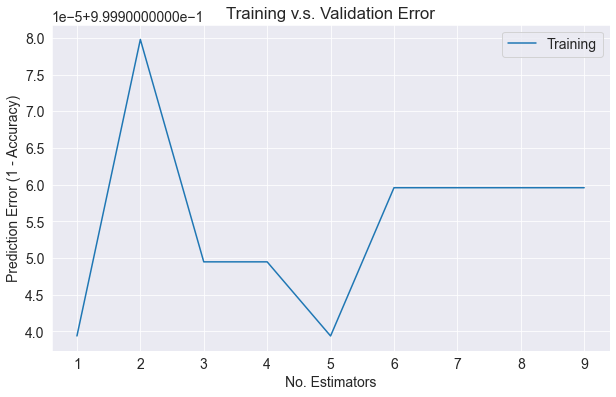

In [244]:
plt.figure()
plt.plot(list(range(1, 10)), errors_df[0])
#plt.plot(list(range(1, 10)), errors_df[1])
plt.title('Training v.s. Validation Error')
# plt.xticks(range(0, 21, 2))
plt.xlabel('No. Estimators')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation'])

### min_samples_split and min_samples_leaf

In [245]:
test_params(min_samples_split=3, min_samples_leaf=2)

(0.9625005051117307, 0.8565956705936975)

In [246]:
test_params(min_samples_split=100, min_samples_leaf=60)

(0.8495676243585081, 0.8451047530613429)

In [248]:
base_accuracy

(0.9999494888269285, 0.8566537055307295)

Can use loop to find optimal values of those

In [59]:
max_acc = 0
opt_s = 1
opt_l = 1

for s in range(2, 100):
    for l in range(2, 100):
        acc = test_params(min_samples_split=s, min_samples_leaf=l)['Validation Error']
        if acc > max_acc:
            max_acc = acc
            opt_s = s
            opt_l = l

opt_l, opt_s, max_acc

(2, 2, 0.8565956705936975)

### Bootstrap
Way to resample (reuse data) to deal with imbalanced data.

In [60]:
test_params(bootstrap=False)

{'Training Error': 0.9999797955307714, 'Validation Error': 0.8567697754047937}

In [66]:
base_accuracy

(0.9999494888269285, 0.8566537055307295)

### max_samples

In [67]:
test_params(max_samples=0.9)

{'Training Error': 0.9997676486038711, 'Validation Error': 0.8565376356566653}

In [68]:
base_accuracy

(0.9999494888269285, 0.8566537055307295)

### class_weight

In [69]:
test_params(class_weight='balanced')

{'Training Error': 0.9999595910615429, 'Validation Error': 0.8553769369160235}

In [70]:
test_params(class_weight={'No': 1, 'Yes': 2})

{'Training Error': 0.9999595910615429, 'Validation Error': 0.8558412164122802}

### Conclude

In [71]:
model = RandomForestClassifier(n_jobs=-1,
                               random_state=42,
                               n_estimators=500,
                               max_features=7,
                               max_depth=30,
                               class_weight={'No': 1, 'Yes': 1.5})

In [72]:
model.fit(X_train, training_y)

RandomForestClassifier(class_weight={'No': 1, 'Yes': 1.5}, max_depth=30,
                       max_features=7, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [74]:
model.score(X_train, training_y), model.score(X_val, validating_y)

(0.9920192346547057, 0.8563054959085369)

In [75]:
base_accuracy

(0.9999494888269285, 0.8566537055307295)

### Strategy

1. Tune the most important first: e.g. n_estimators
2. With above value, tune next one
3. keep going
4. loop again see if can get improvement

## Saving and Loading Models

In [76]:
import joblib

In [77]:
aussie_rain = {
    'model': model,
    'imputer': imputer,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': x_cols,
    'target_col': y_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

In [78]:
joblib.dump(aussie_rain, 'aussie_rain.joblib')

['aussie_rain.joblib']

In [79]:
aussie_rain2 = joblib.load('aussie_rain.joblib')

In [83]:
test_preds2 = aussie_rain2['model']
test_preds2.score(X_test, testing_y)

0.8451913451913452